# Summary

This notebook dives into the world of time series using ARIMA, SARIMAX and LSTMs. These models are great for analyzing time series information as the information for time series is not independent and identically distributed (IID).

### <b>Business Problem</b>

The stakeholder for this project will be a trading firm interested in trading Rivian Stock.

### <b>Data Exploration and Understanding</b>

The information provided in this notebook was provided by Yahoo Finance. The data was downloaded as a CSV and attached to the repository where this notebook is located. Rivian had a strong start to it's price and fell drastically between around December 2021 and May 2022. There were some peaks and valleys in this period but overall, the price fell. After May 2022, the price fairly stabilized, hovering around the $30 mark. The daily return percentage on the stock. If look at the range for the overall daily return from Rivian's stock, it falls between ~0.2% and -0.2%. The daily return does not have a noticable trend associated to it. The monthly return on the stock also ranges to not too far from the daily price with a range of ~ 0.3% and -0.4%. However, the monthly return shows that could be an upward trend over time.

### <b>Data Preparation</b>

When preparing the data, the primary trend that was of focus was the closing price of the stock. Stocks traditional trade from Mon-Fri so there were gaps in the data. For model preparation for ARIMA models, it did not do well with gaps so the days missing were filled in with the friday's values. This still makes sense as the price of the stock does not change over the weekend and the price on monday starts from that value. It did modify the trend line slightly but it was still extremely useable. There were checks of stationarity as ARIMA models make this assumption. Adding a difference of 1 did make the trend stationary. ACF and PACF plots were used to determine the AR and MA portions of the ARIMA model. Train-test splits were used for the ARIMA model but for the LSTM models, there was a mixture of train-test splits and train-val-test splits.

### <b> Modeling</b>
There were few types of models used in this notebook. There was an I model (Random Walk), ARI (AR + I terms) and an AutoARIMA model. The I model was used as the baseline model to compare against. The ARI model used the recommendations interpreted based on the ACF and PACF plots. Each model was able to get produced using the SARIMAX module. The AutoARIMA model produced a result that utilized the full SARIMAX model. 

Two methods of LSTM models were used. The first method included using a windowed dataframe based on the amount of days chosen by the person running the model (in this case 30 days). Based on the windowed dataframe, the LSTM model made prediction both recursively and against the validation and test sets. The second method used a regular train test split and did not include a validation set inside of the LSTM model. The model made predictions both recursively and against the test set. Both methods used almost the same structure as the first iteration had an LSTM input layer, 3 dense layers and included a 0.2 dropout. The second iteration had an LSTM input layer, 3 dense layers with no dropout. What fundamentally different were the shapes added to the input layer.

### <b>Evaluation</b>

Each model was evaluated against the test set and a recursive date set. While the test set acts as a set in which the dataset has not seen before, the recursive set can be adjusted to predict however long into the future the user wants to set. In this notebook, the dates were set to the same length as the test set but was completely blank as if it was really predicting into the future with no real values to associate to. The results were then plotted to check for noticeable differences.

### <b>Conclusion</b>

The best performing model was the AutoARIMA chosen model. It was the closest in the recursive test to the value. A note however, all models performed decent for next day performance but as it tried to predict farther into the future, all of the models ended up leveling out into just 1 price and could not predict well into the future.

# Data Exploration

In [1]:
#Importing the necessary packages
from copy import deepcopy
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from pmdarima.arima import ADFTest

In [2]:
#Importing the data
riv_stock_df = pd.read_csv('data/RIVN.csv', index_col = ['Date'], parse_dates=['Date'])
riv_stock_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800
2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300
2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600


In [3]:
#Checking the information
riv_stock_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241 entries, 2021-11-10 to 2022-10-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       241 non-null    float64
 1   High       241 non-null    float64
 2   Low        241 non-null    float64
 3   Close      241 non-null    float64
 4   Adj Close  241 non-null    float64
 5   Volume     241 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.2 KB


In [4]:
#Converting date format to datetime for future plotting and calculations
riv_df = riv_stock_df.asfreq('D').ffill()

In [5]:
#Checking information
riv_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500.0
2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200.0
2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800.0
2021-11-13,128.645004,135.199997,125.250000,129.949997,129.949997,50636800.0
2021-11-14,128.645004,135.199997,125.250000,129.949997,129.949997,50636800.0


In [6]:
#Checking for any missing values
riv_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
#Checking to see if the index was read in properly
riv_df.index[0].month

11

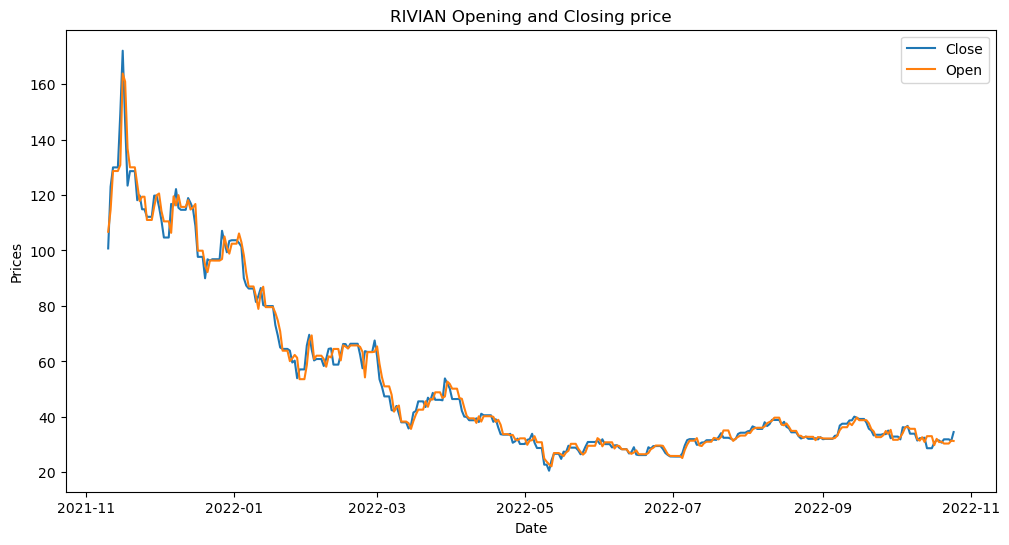

In [8]:
#Plotting the opening and closing price
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Prices')
plt.plot(riv_df['Close'])
plt.plot(riv_df['Open'])
plt.title('RIVIAN Opening and Closing price')
plt.legend(['Close', 'Open'])
plt.show()

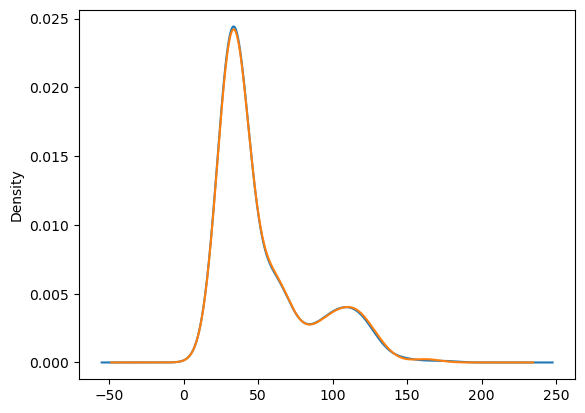

In [9]:
#Checking distribution of the dataset
riv_df_close = riv_df['Close']
riv_df_open = riv_df['Open']
riv_df_close.plot(kind='kde')
riv_df_open.plot(kind='kde');

In [10]:
#https://www.codingfinance.com/post/2018-04-03-calc-returns-py/
#Calculating daily and monthly return
riv_daily_return = pd.DataFrame(riv_df['Adj Close'].pct_change())
riv_monthly_return=pd.DataFrame(riv_df['Adj Close'].resample('M').ffill().pct_change())

In [11]:
#Chceking output
riv_daily_return

,Adj Close
Date,
2021-11-10,NaN
2021-11-11,0.220987
2021-11-12,0.056590
2021-11-13,0.000000
2021-11-14,0.000000
...,...
2022-10-21,0.038724
2022-10-22,0.000000
2022-10-23,0.000000


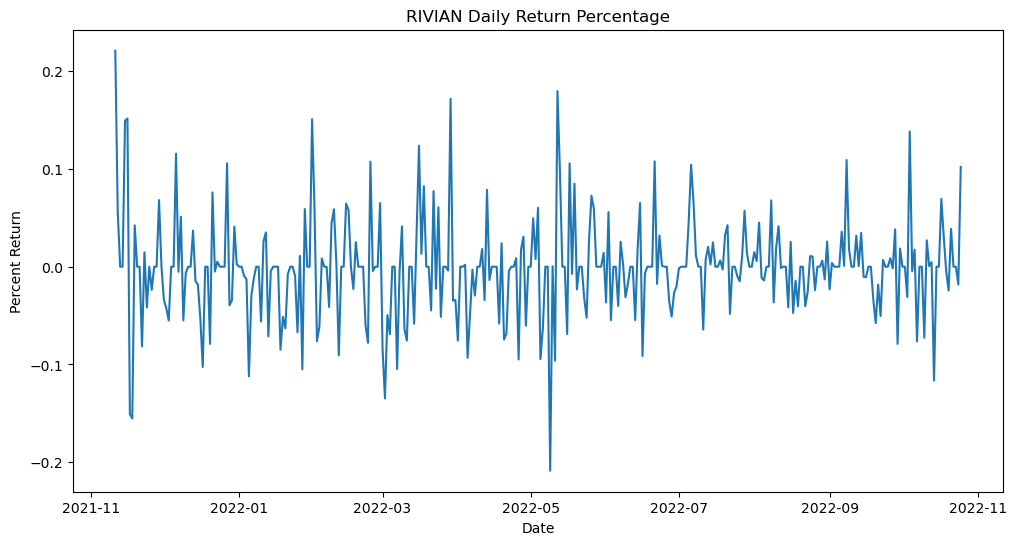

In [12]:
#Visualizing daily return
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.plot(riv_daily_return)
plt.title('RIVIAN Daily Return Percentage')
plt.show()

In [13]:
#Checking output
riv_monthly_return

,Adj Close
Date,
2021-11-30,NaN
2021-12-31,-0.134185
2022-01-31,-0.365995
2022-02-28,0.027685
2022-03-31,-0.256365
2022-04-30,-0.398089
2022-05-31,0.038360
2022-06-30,-0.180255
2022-07-31,0.332556


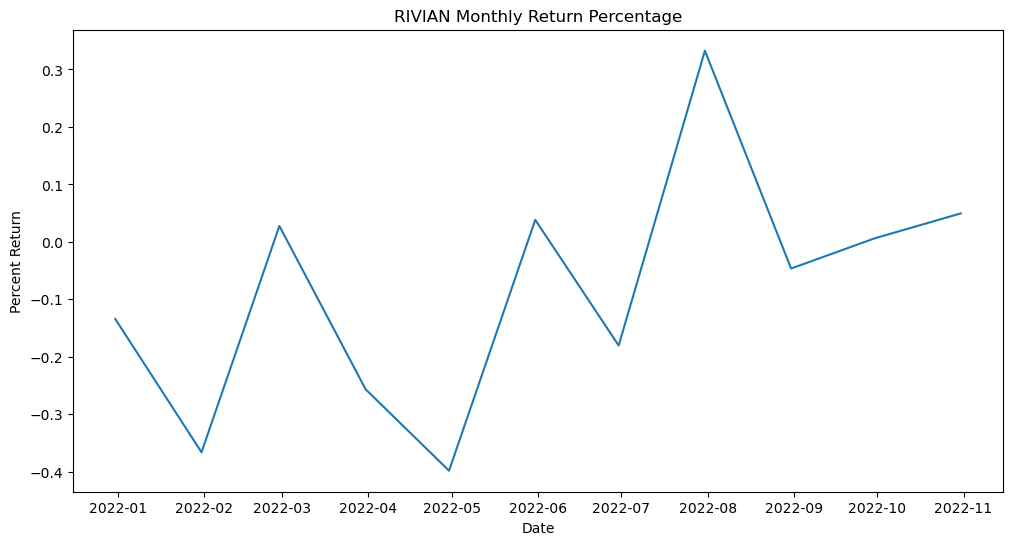

In [14]:
#Visualizing monthly return
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Percent Return')
plt.plot(riv_monthly_return)
plt.title('RIVIAN Monthly Return Percentage')
plt.show()

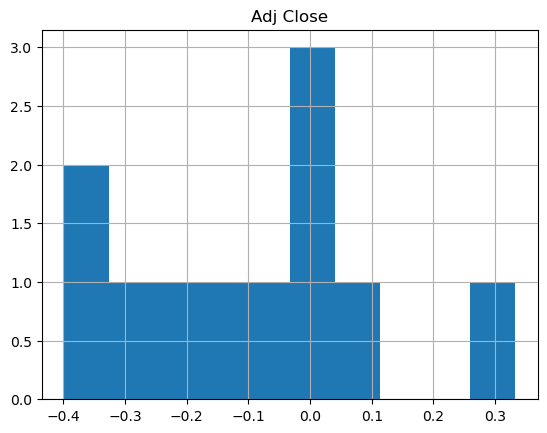

In [15]:
#Visualizing distribution of the monthly return
riv_monthly_return.hist();

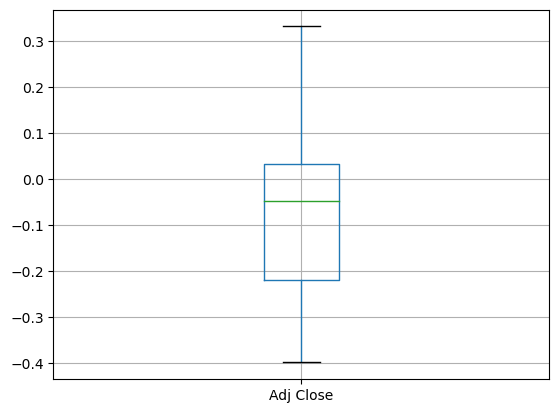

In [16]:
#Visualizing for extreme outliers in the dataset
riv_monthly_return.boxplot();

In [17]:
# https://blog.devgenius.io/how-to-calculate-the-daily-returns-and-volatility-of-a-stock-with-python-d4e1de53e53b
#Calculating Volatility
daily_volatility_rivn = riv_daily_return['Adj Close'].std()
print('Daily volatility: \n --------------')
print('Rivian: ', '{:.2f}%'.format(daily_volatility_rivn))
print('\n')
monthly_volatility_rivn = math.sqrt(21) * daily_volatility_rivn
print('Monthly volatility: \n --------------')
print ('Rivian: ', '{:.2f}%'.format(monthly_volatility_rivn))
print('\n')
annual_volatility_rivn = math.sqrt(252) * daily_volatility_rivn
print('Annual volatility: \n --------------')
print ('Rivian: ', '{:.2f}%'.format(annual_volatility_rivn ))

Daily volatility: 
 --------------
Rivian:  0.05%


Monthly volatility: 
 --------------
Rivian:  0.23%


Annual volatility: 
 --------------
Rivian:  0.81%


# Model Preparation

In [18]:
# Creating function for assessment
def test_trend(ts_df):
    """
    This function provides a visualization of the original tend, rolling mean and rolling standard deviation. It also 
    provides the results of an Adjusted Dickey-Fuller test and KPSS test.
    
    """
    #Getting rolling statistics
    roll_mean = ts_df.rolling(11).mean()
    roll_std = ts_df.rolling(11).std()
    #Plotting rolling statistics
    fig = plt.figure(figsize=(12,7))
    plt.plot(ts_df, color='blue', label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print("Results of the Dickey-Fuller Test")
    dftest = adfuller(ts_df)
    # Output for dickey-fuller test will give us the values without defining what the values are.
    # Manually writing the values
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in dftest[4].items():
        dfoutput['critical value (%s)'%key] =  values
    print(dfoutput)
    print('\n\n')
    print("Results of KPSS Test:")
    kpsstest = kpss(ts_df, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

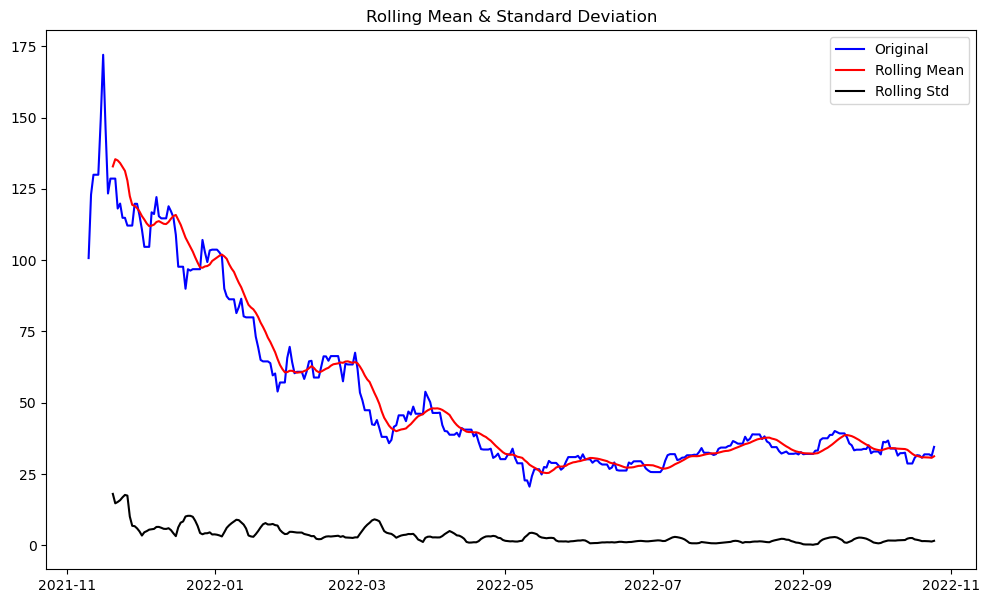

Results of the Dickey-Fuller Test
Test Statistics                 -2.963177
p-value                          0.038479
No. of lags used                15.000000
Number of observations used    334.000000
critical value (1%)             -3.450081
critical value (5%)             -2.870233
critical value (10%)            -2.571401
dtype: float64



Results of KPSS Test:
Test Statistic            2.191895
p-value                   0.010000
Lags Used                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [19]:
#Visualizing the rolling mean, rolling standard deviation and the original line
test_trend(riv_df['Close'])

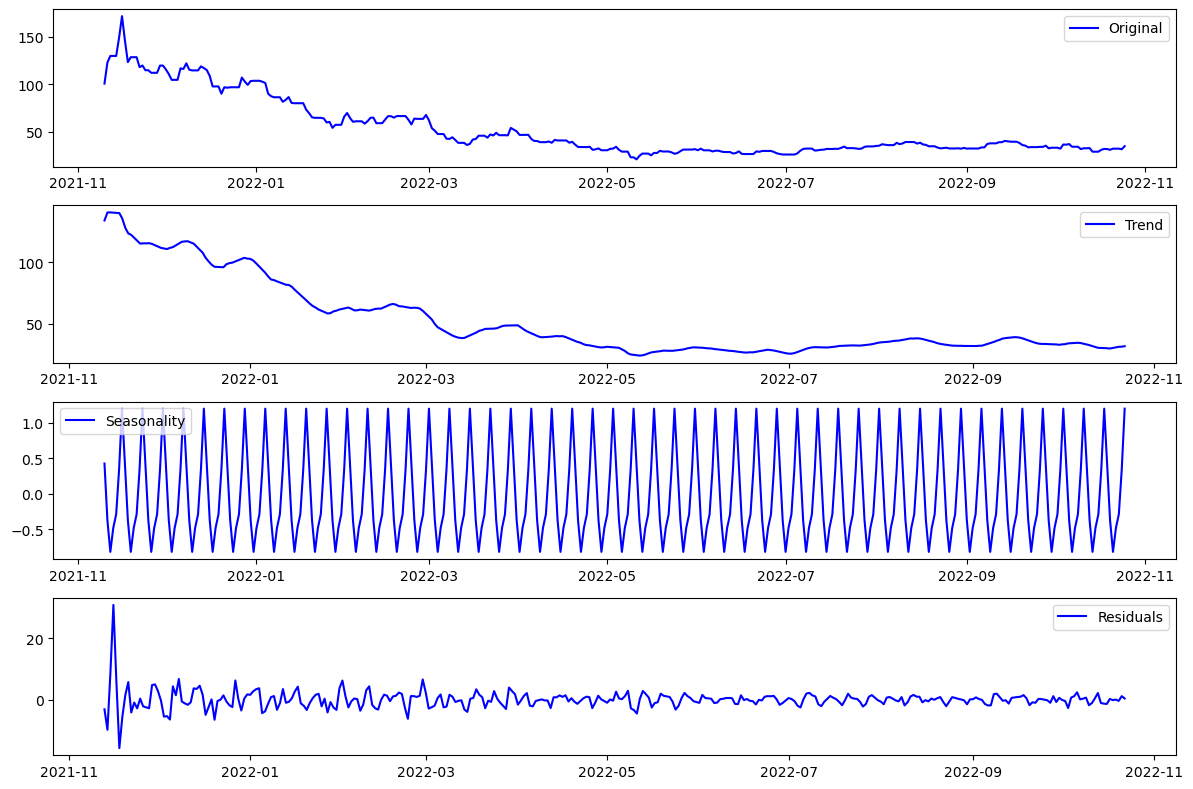

In [20]:
#Decomposing the closing data
decomposition = seasonal_decompose(riv_df['Close'].asfreq('d').ffill(), model = "additive")

# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid

# Plotting original, trend, seasonality, residuals
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(riv_df_close, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

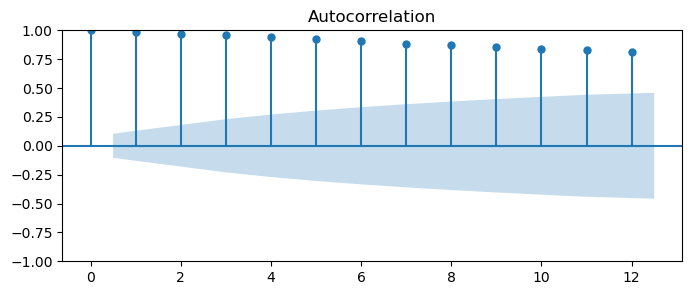

In [21]:
#Plotting the AutoCorrelation function
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(riv_df['Close'],ax=ax, lags=12);

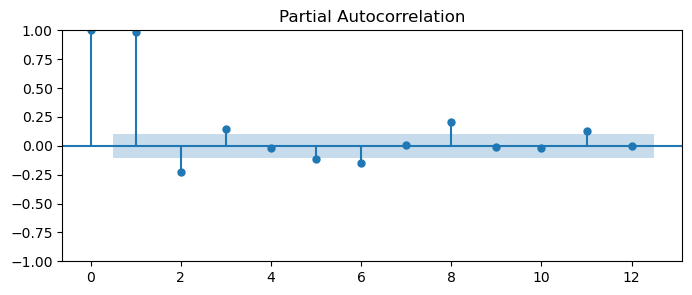

In [22]:
#Plotting the Partial AutoCorrelation Function
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(riv_df['Close'],ax=ax, lags=12, method='ywm');

## Removing the trend

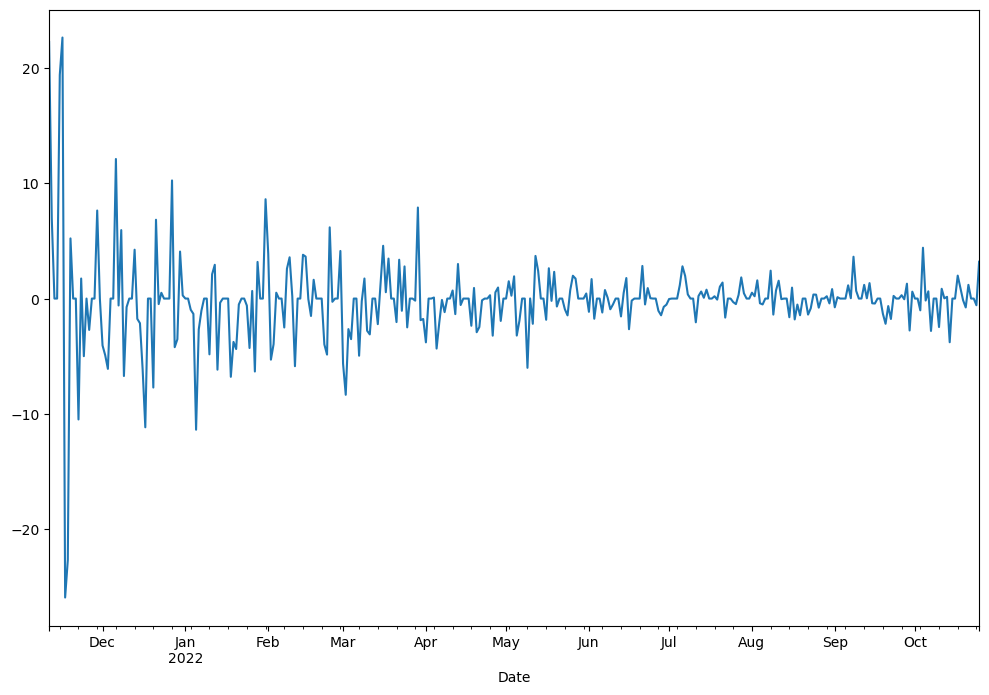

In [23]:
#Shifting the data 1 lag and subtracting it from original data
riv_df["close_diff"] = riv_df['Close'] - riv_df['Close'].shift(1)
riv_df["close_diff"].dropna().plot(figsize=(12, 8));

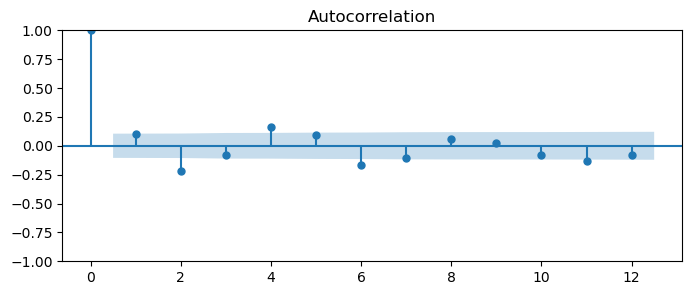

In [24]:
#Plotting the AutoCorrelation function
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(riv_df["close_diff"].dropna(),ax=ax, lags=12);

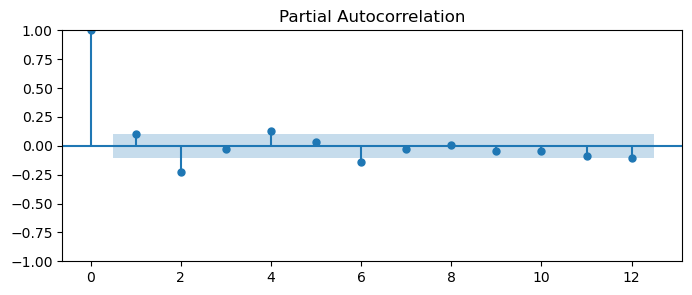

In [25]:
#Plotting the Partial AutoCorrelation Function
fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(riv_df["close_diff"].dropna(),ax=ax, lags=12, method='ywm');

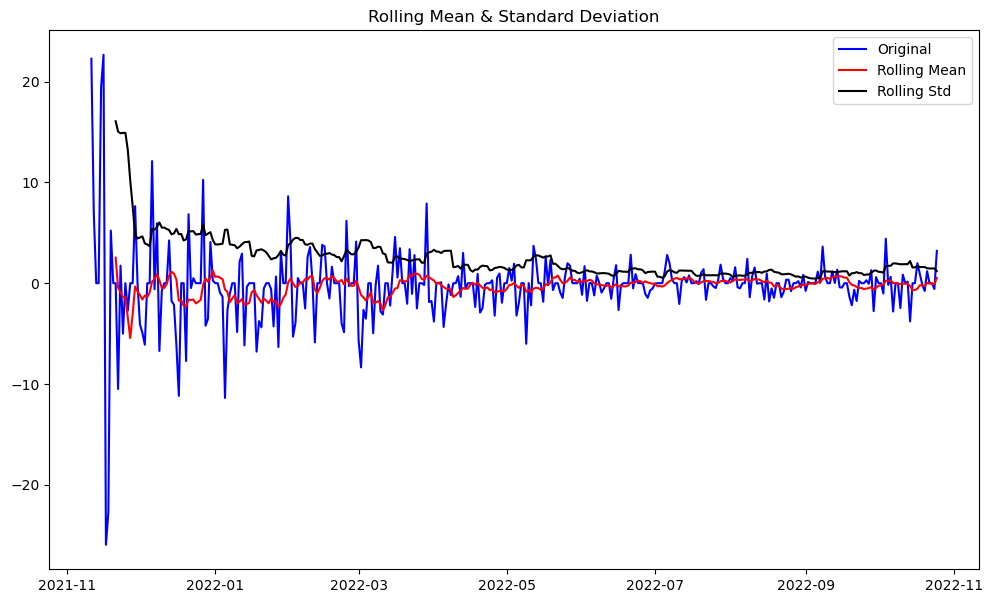

Results of the Dickey-Fuller Test
Test Statistics                 -5.271665
p-value                          0.000006
No. of lags used                17.000000
Number of observations used    331.000000
critical value (1%)             -3.450262
critical value (5%)             -2.870312
critical value (10%)            -2.571443
dtype: float64



Results of KPSS Test:
Test Statistic            0.161239
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [26]:
#Checking tests on shifted data
test_trend(riv_df['close_diff'].dropna())

In [27]:
#Splitting the Closing price into train and test with train 80% and test 20%
train, test = train_test_split(riv_df['Close'],test_size=.2,shuffle=False)

In [28]:
#Checking train
train

Date
2021-11-10    100.730003
2021-11-11    122.989998
2021-11-12    129.949997
2021-11-13    129.949997
2021-11-14    129.949997
                 ...    
2022-08-12     38.900002
2022-08-13     38.900002
2022-08-14     38.900002
2022-08-15     37.279999
2022-08-16     38.230000
Freq: D, Name: Close, Length: 280, dtype: float64

In [29]:
#Checking test
test

Date
2022-08-17    36.419998
2022-08-18    35.900002
2022-08-19    34.450001
2022-08-20    34.450001
2022-08-21    34.450001
                ...    
2022-10-21    31.920000
2022-10-22    31.920000
2022-10-23    31.920000
2022-10-24    31.340000
2022-10-25    34.540001
Freq: D, Name: Close, Length: 70, dtype: float64

In [30]:
#Turning train into a datatframe
train = pd.DataFrame(train, index = train.index)

In [31]:
#Checking output
train

,Close
Date,
2021-11-10,100.730003
2021-11-11,122.989998
2021-11-12,129.949997
2021-11-13,129.949997
2021-11-14,129.949997
...,...
2022-08-12,38.900002
2022-08-13,38.900002
2022-08-14,38.900002


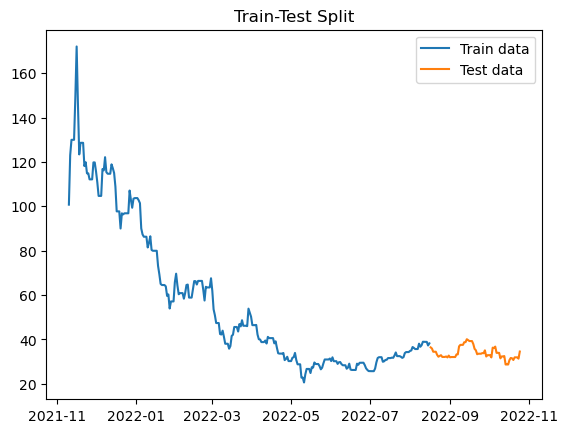

In [32]:
#Plotting train and split
fig, ax = plt.subplots()
ax.plot(train, label = 'Train data')
ax.plot(test, label = 'Test data')

ax.set_title("Train-Test Split")

plt.legend();


# Modeling

## Random Walk model (I only)

In [33]:
#Modeling random walk model
I_model = SARIMAX(train, order=(0,1,0)).fit()
I_model.predict(typ='levels')

Date
2021-11-10      0.000000
2021-11-11    100.730003
2021-11-12    122.989998
2021-11-13    129.949997
2021-11-14    129.949997
                 ...    
2022-08-12     38.950001
2022-08-13     38.900002
2022-08-14     38.900002
2022-08-15     38.900002
2022-08-16     37.279999
Freq: D, Name: predicted_mean, Length: 280, dtype: float64

In [34]:
#Checking the summary of the information
I_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  280
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -794.884
Date:                Thu, 17 Nov 2022   AIC                           1591.769
Time:                        12:52:09   BIC                           1595.400
Sample:                    11-10-2021   HQIC                          1593.225
                         - 08-16-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        17.4653      0.513     34.044      0.000      16.460      18.471
===================================================================================
Ljung-Box (L1) (Q):                   3.41   Jarque-Bera (JB):              2518.40
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
#Checking the aic of the model
I_model.aic

1591.768525655039

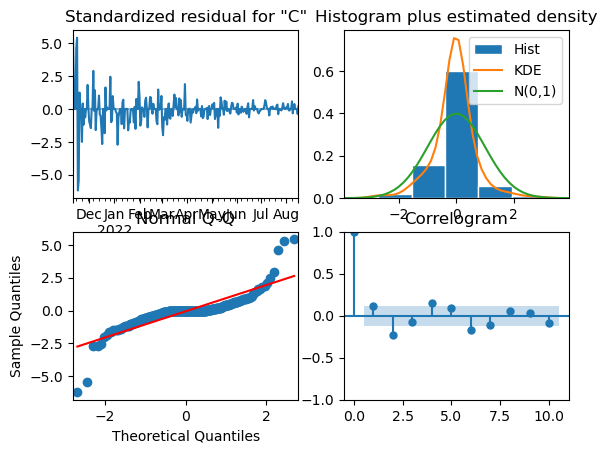

In [36]:
#Plotting the residuals
I_model.plot_diagnostics()
plt.show()

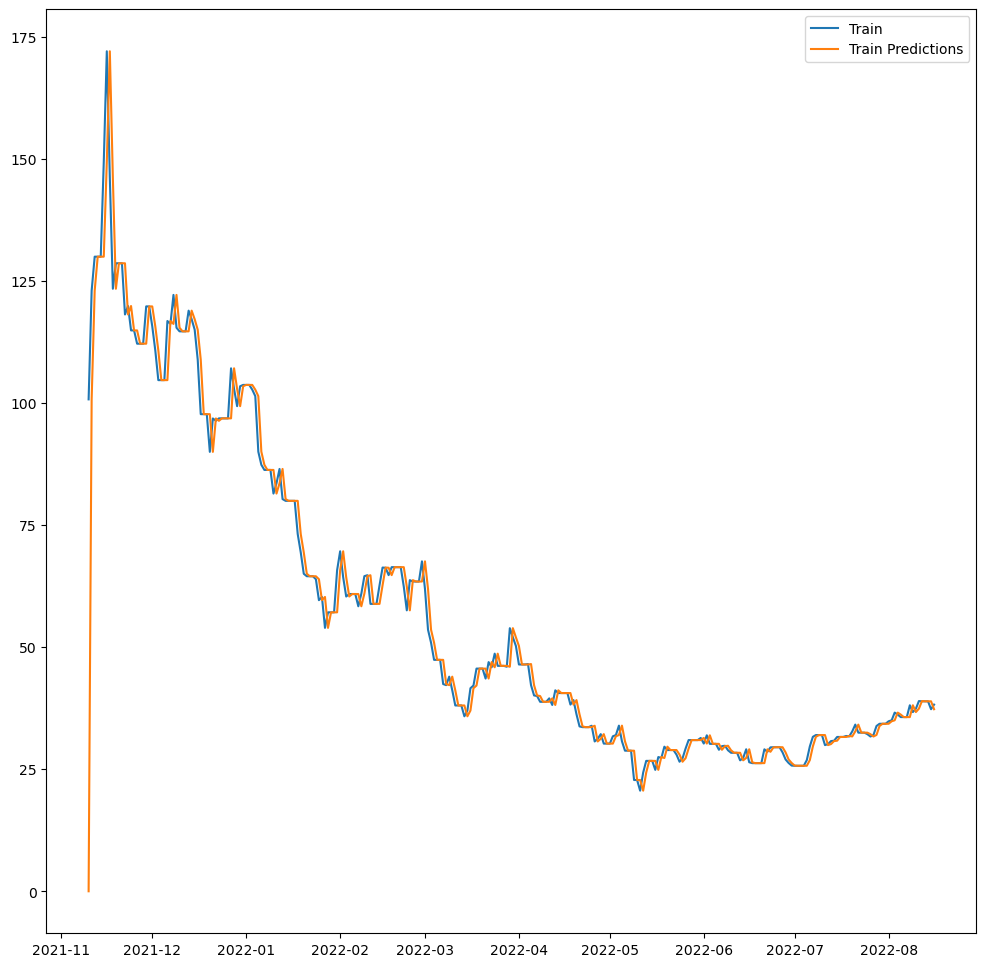

In [37]:
#Plotting the original train and the predictions
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(train, label = 'Train')
plt.plot(I_model.predict(typ='levels'), label = 'Train Predictions')
plt.legend(loc='best');


In [38]:
def future_df(train):
    """
    This function creates a dataframe that has null for the new dates that match the test set. The range should be adjusted
    to however long the user wants to predictions to be predicted for.
    """
    future_dates = [train.index[-1] + DateOffset(days=x) for x in range(0,71)]
    future_dataset_df=pd.DataFrame(index = future_dates[1:], columns = train.columns)
    future_df_i = pd.concat([train, future_dataset_df])
    return future_df_i

In [39]:
future_df_i = future_df(train)
future_df_i

,Close
2021-11-10,100.730003
2021-11-11,122.989998
2021-11-12,129.949997
2021-11-13,129.949997
2021-11-14,129.949997
...,...
2022-10-21,NaN
2022-10-22,NaN
2022-10-23,NaN
2022-10-24,NaN


In [40]:
#Checking the shape of the information
future_df_i.shape

(350, 1)

In [41]:
#Checking to see wha the final index is
future_df_i.index[280]

Timestamp('2022-08-17 00:00:00')

In [42]:
#Using the model to predict future values
future_df_i['forecast'] = I_model.predict(start = future_df_i.index[280], end = future_df_i.index[349])

In [43]:
future_df_i

,Close,forecast
2021-11-10,100.730003,NaN
2021-11-11,122.989998,NaN
2021-11-12,129.949997,NaN
2021-11-13,129.949997,NaN
2021-11-14,129.949997,NaN
...,...,...
2022-10-21,NaN,38.23
2022-10-22,NaN,38.23
2022-10-23,NaN,38.23
2022-10-24,NaN,38.23


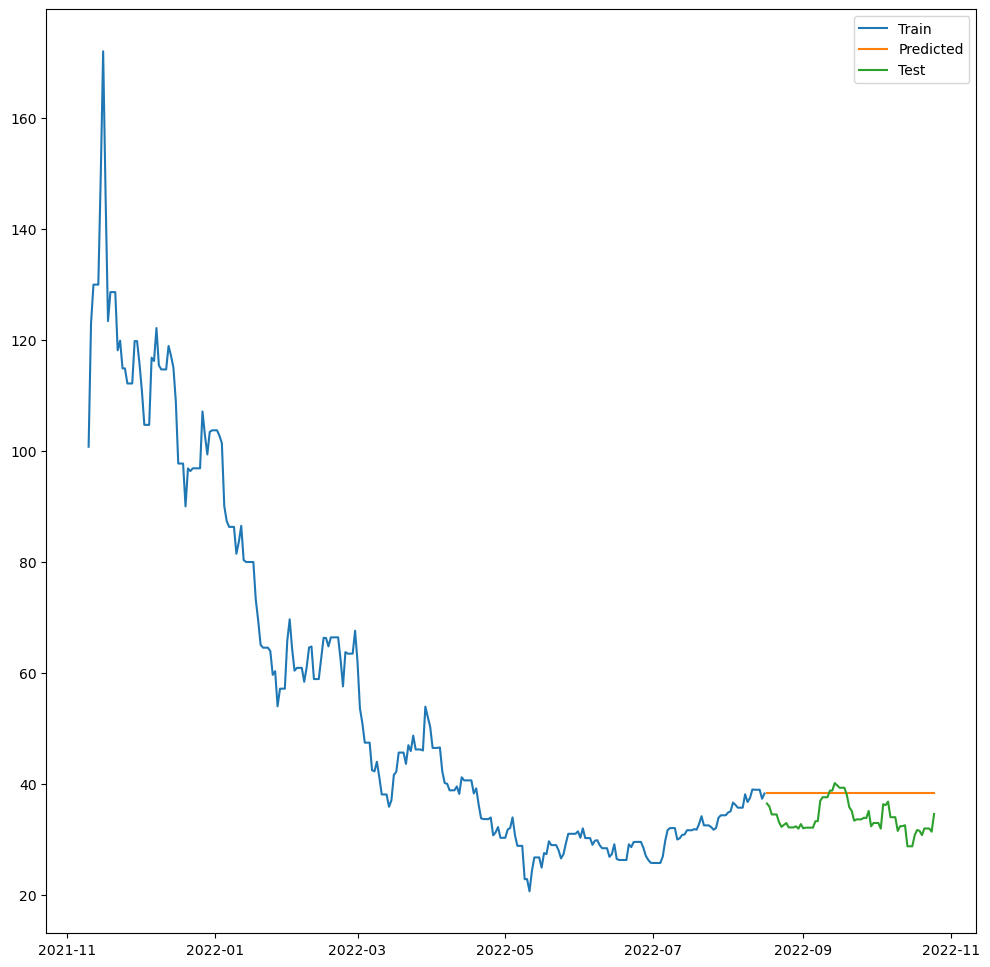

In [44]:
#Visualizing result
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(future_df_i['Close'], label = 'Train')
plt.plot(future_df_i['forecast'], label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc='best');

## ARIMA model (ARI)

In [45]:
# Modeling 1 auto regressive term and 1 difference
ARI_model = SARIMAX(train, order=(1,1,0)).fit()
ARI_model.predict(typ='levels')

Date
2021-11-10      0.000000
2021-11-11    100.730225
2021-11-12    125.795424
2021-11-13    130.827165
2021-11-14    129.949997
                 ...    
2022-08-12     39.145347
2022-08-13     38.893701
2022-08-14     38.900002
2022-08-15     38.900002
2022-08-16     37.075830
Freq: D, Name: predicted_mean, Length: 280, dtype: float64

In [46]:
#Checking the summary
ARI_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  280
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -792.872
Date:                Thu, 17 Nov 2022   AIC                           1589.744
Time:                        12:52:12   BIC                           1597.006
Sample:                    11-10-2021   HQIC                          1592.657
                         - 08-16-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1260      0.018      6.885      0.000       0.090       0.162
sigma2        17.2142      0.503     34.252      0.000      16.229      18.199
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):              2703.87
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

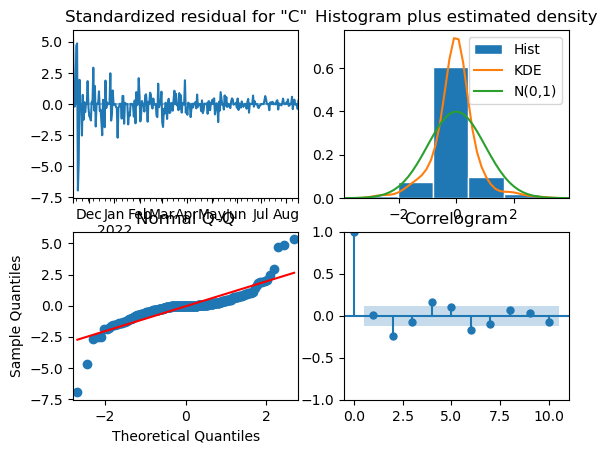

In [47]:
#Plotting the outcome
ARI_model.plot_diagnostics()
plt.show()

In [48]:
#Checking the aic
ARI_model.aic

1589.743746223436

In [49]:
#Comparing the aic to the previous model
print("Random Walk AIC: {}".format(I_model.aic))
print("ARI AIC: {}".format(ARI_model.aic))

Random Walk AIC: 1591.768525655039
ARI AIC: 1589.743746223436


In [50]:
#Checking the root mean squared error of the previous model
y_hat_imodel = I_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_imodel))

7.323972799159354

In [51]:
#Checking the root mean squared error of the ari model
y_hat_arimodel = ARI_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_arimodel))

7.308792819748108

In [52]:
#Checking the parameters given by the model
ARI_model.arparams

array([0.12602995])

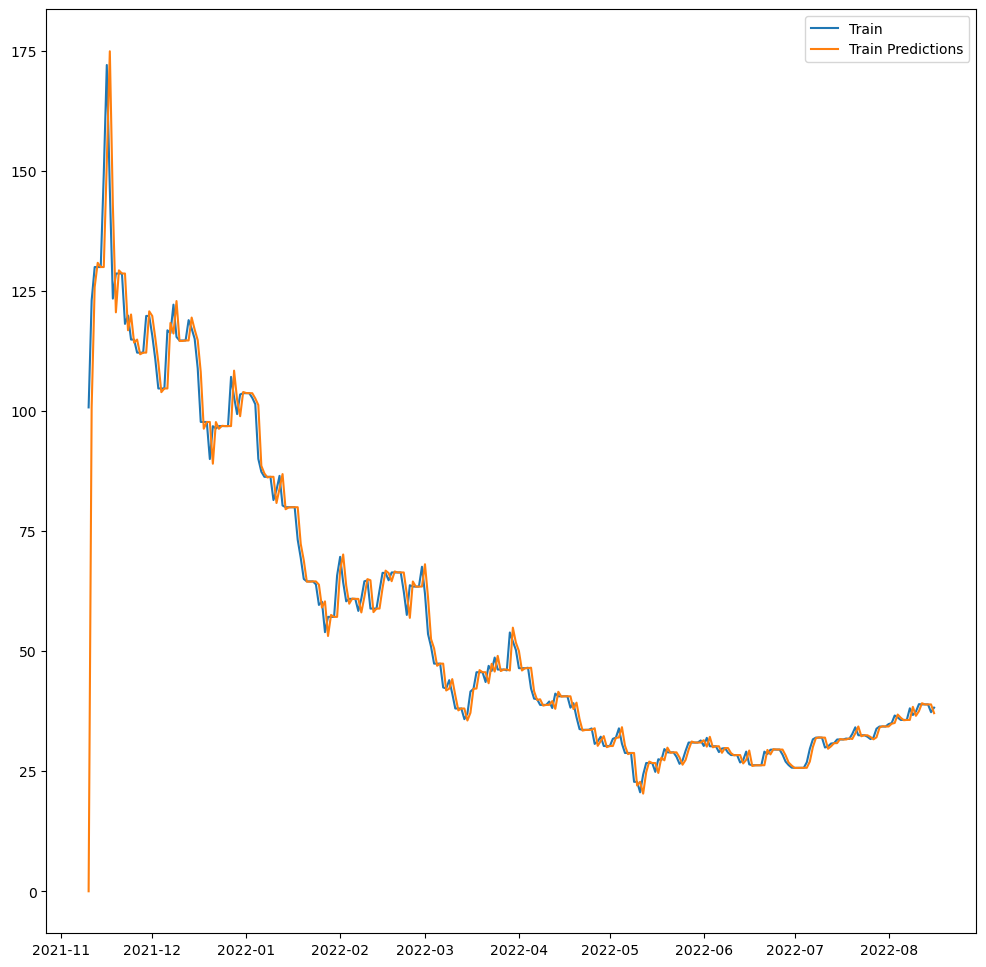

In [53]:
#Plotting the train predictions to the train set
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(train, label = 'Train')
plt.plot(ARI_model.predict(typ='levels'), label = 'Train Predictions')
plt.legend(loc='best');

In [54]:
#Creating a future values dataframe
future_df_ari = future_df(train)
future_df_ari

,Close
2021-11-10,100.730003
2021-11-11,122.989998
2021-11-12,129.949997
2021-11-13,129.949997
2021-11-14,129.949997
...,...
2022-10-21,NaN
2022-10-22,NaN
2022-10-23,NaN
2022-10-24,NaN


In [55]:
#Predicting the future using the empty values
future_df_ari['forecast'] = ARI_model.predict(start = future_df_ari.index[280], end = future_df_ari.index[349])
future_df_ari

,Close,forecast
2021-11-10,100.730003,NaN
2021-11-11,122.989998,NaN
2021-11-12,129.949997,NaN
2021-11-13,129.949997,NaN
2021-11-14,129.949997,NaN
...,...,...
2022-10-21,NaN,38.366994
2022-10-22,NaN,38.366994
2022-10-23,NaN,38.366994
2022-10-24,NaN,38.366994


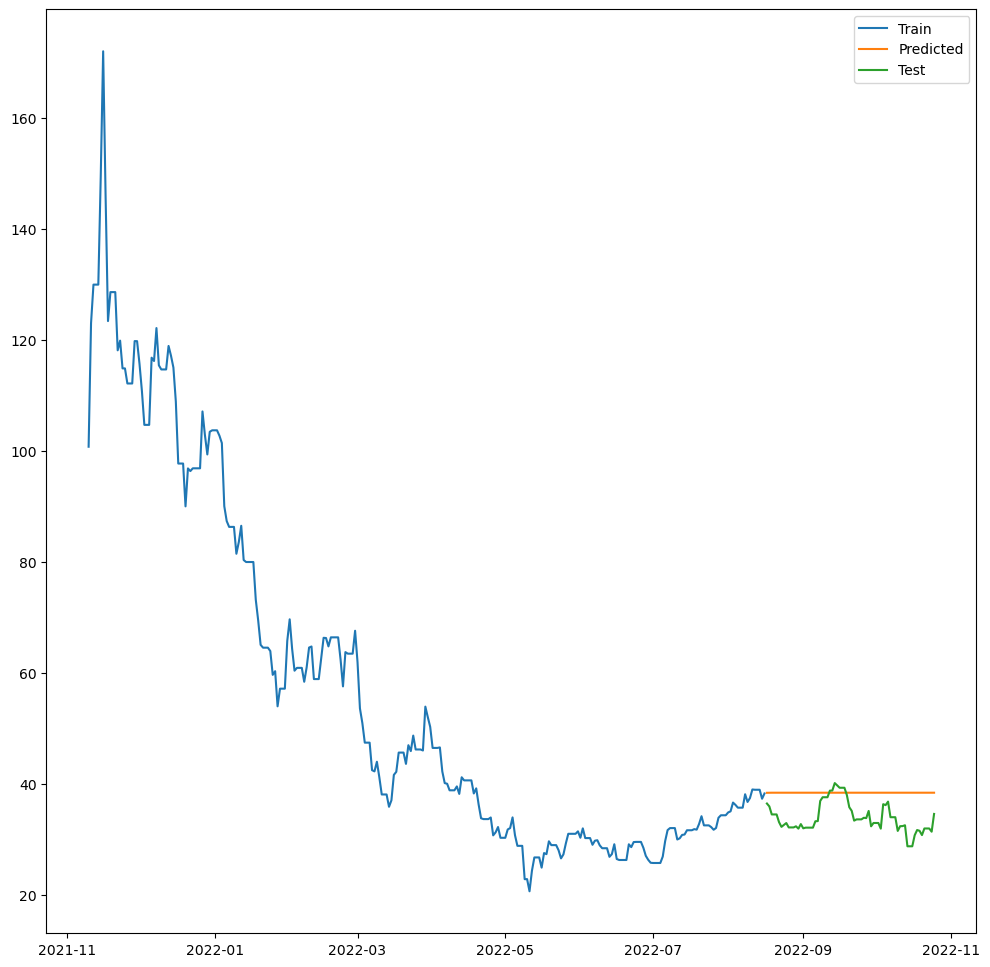

In [56]:
#Plotting the predictions vs the test.
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(future_df_ari['Close'], label = 'Train')
plt.plot(future_df_ari['forecast'], label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc='best');

## AutoARIMA

In [57]:
#Using the autoarima model to find the best parameters for an arima model
auto_model_params = pm.arima.auto_arima(train, error_action = 'warn', m= 12,
                                          start_p= 0, start_d = 0, start_q = 0, 
                                          start_P = 0, start_D = 0, start_Q = 0, trace = True, 
                                          supress_warning = True, 
                                          stepwise = False, 
                                          random_state = 1)

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1592.966, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1592.134, Time=0.21 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1592.770, Time=0.56 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1591.626, Time=0.23 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1592.311, Time=0.53 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1593.202, Time=0.83 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1593.009, Time=0.56 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1594.084, Time=0.87 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1592.470, Time=1.80 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1587.886, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1586.832, Time=0.32 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1587.001, Time=0.73 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1586.244, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1587.801, Time=0.58 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1588.141, Time=0.99

In [58]:
#Checking the summary
auto_model_params.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  280
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                -772.300
Date:                             Thu, 17 Nov 2022   AIC                           1558.601
Time:                                     12:53:32   BIC                           1584.019
Sample:                                 11-10-2021   HQIC                          1568.797
                                      - 08-16-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.5798      0.495     -1.172      0.241      -1.549       0.390
ar.L1          0.0950      0.022      4.230      0.000       0.051       0.139
ar.L2         -0.9555      0.014    -66.440      0.000      -0.984      -0.927
ma.L1          0.0090      0.036      0.252      0.801      -0.061       0.079
ma.L2          0.7864      0.049     15.895      0.000       0.689       0.883
ar.S.L12      -0.2042      0.062     -3.294      0.001      -0.326      -0.083
sigma2        14.7644      0.734     20.112      0.000      13.326      16.203
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):               568.64
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX based on autoarima

In [59]:
#Modeling the the autogressive, different, moving average, seasonal component and exogenous factors
auto_ARI_model = SARIMAX(train, order=(2,1,2), seasonal_order=(1,0,0,12)).fit()
auto_ARI_model

In [60]:
#Checking AIC vs previous models
print("Random Walk AIC: {}".format(I_model.aic))
print("ARI AIC: {}".format(ARI_model.aic))
print("Auto-ARI AIC: {}".format(auto_ARI_model.aic))

Random Walk AIC: 1591.768525655039
ARI AIC: 1589.743746223436
Auto-ARI AIC: 1558.5028837053057


C:\Users\Jonathan\anaconda3\envs\time-series-env\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


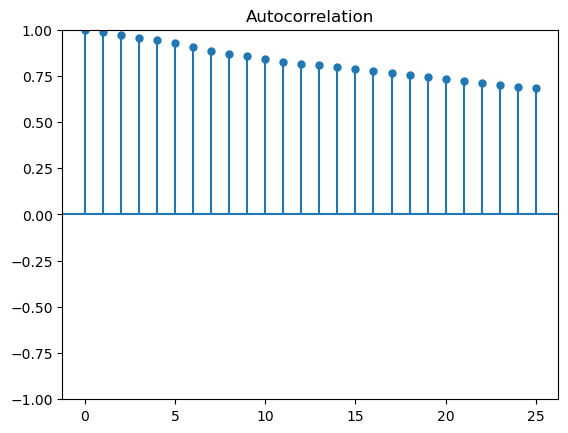

In [61]:
#Plotting auto correlation function
pm.plot_acf(train)

In [62]:
#Plotting adjusted dickey-fuller test
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(train)
print(p_val, should_diff)

0.282751686124863 True


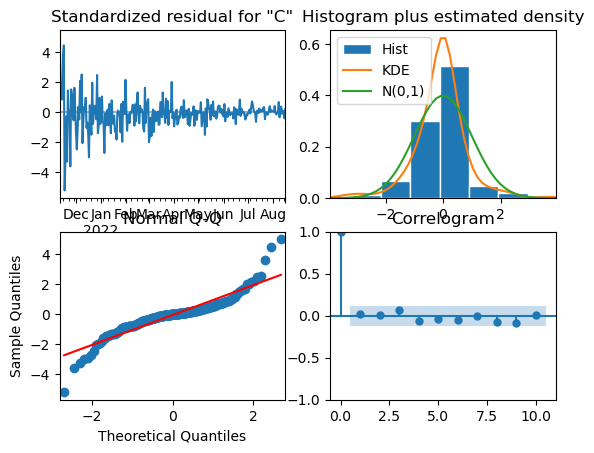

In [63]:
#Plotting the residuals of the model
auto_ARI_model.plot_diagnostics()
plt.show()

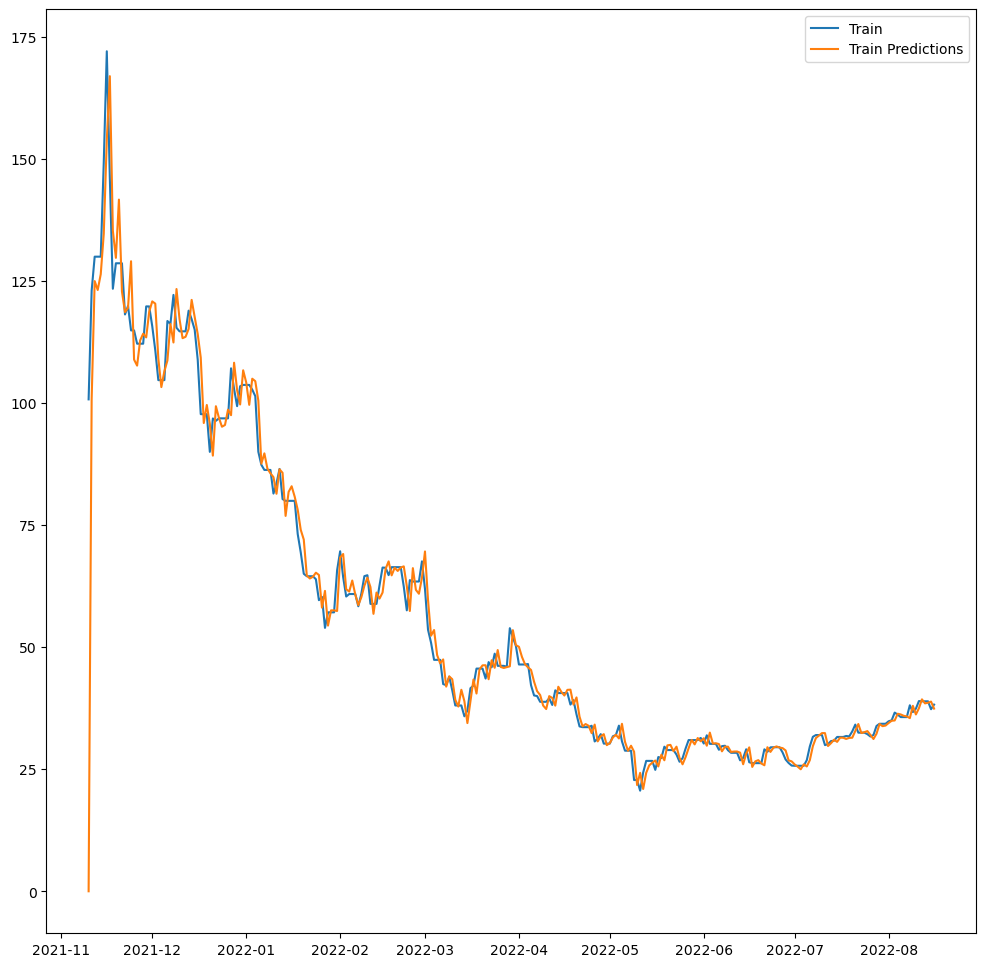

In [64]:
#visualizing train predictions again the train set
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(train, label = 'Train')
plt.plot(auto_ARI_model.predict(typ='levels'), label = 'Train Predictions')
plt.legend(loc='best');

In [65]:
#Creating future dataframe with empty future values
future_df_auto_ari = future_df(train)
future_df_auto_ari

,Close
2021-11-10,100.730003
2021-11-11,122.989998
2021-11-12,129.949997
2021-11-13,129.949997
2021-11-14,129.949997
...,...
2022-10-21,NaN
2022-10-22,NaN
2022-10-23,NaN
2022-10-24,NaN


In [66]:
#Forecasting future dates
future_df_auto_ari['forecast'] = auto_ARI_model.predict(start = future_df_auto_ari.index[280], end = future_df_auto_ari.index[349])
future_df_auto_ari

,Close,forecast
2021-11-10,100.730003,NaN
2021-11-11,122.989998,NaN
2021-11-12,129.949997,NaN
2021-11-13,129.949997,NaN
2021-11-14,129.949997,NaN
...,...,...
2022-10-21,NaN,37.870647
2022-10-22,NaN,37.896282
2022-10-23,NaN,37.869918
2022-10-24,NaN,37.843035


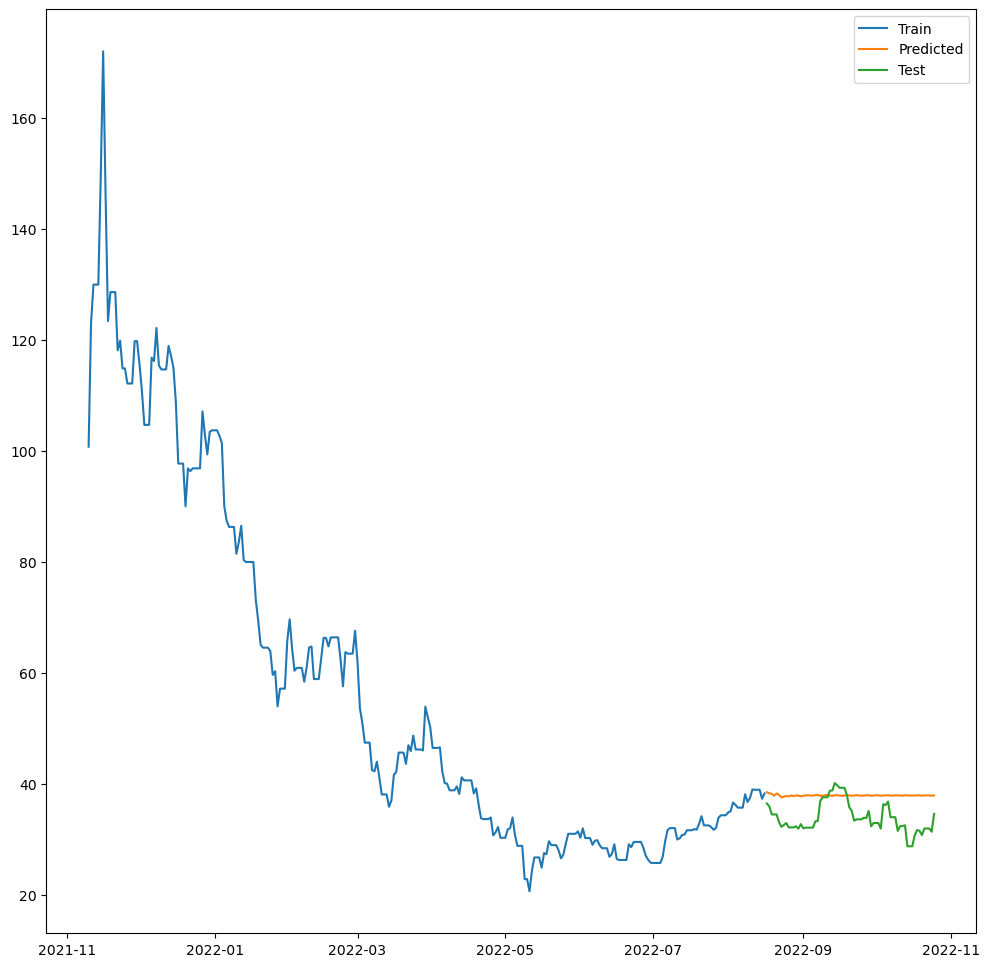

In [67]:
#Visualzing future dates
fig, ax = plt.subplots(figsize = (12,12))
plt.plot(future_df_auto_ari['Close'], label = 'Train')
plt.plot(future_df_auto_ari['forecast'], label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc='best');

# LSTM Method 1

## Functions

In [68]:
def evaluate_nn(history):
    '''
    This function plots the training accuracy, validation accuracy, training loss and validation loss from a fitted keras model.
    It gets this information from the history.history and the metric attributed to the model.
    
    '''
    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'blue', label = 'Training MAE')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation MAE')
    plt.title('Training and Validation MAE')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'blue', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'orange', label= 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

In [69]:
# https://www.youtube.com/watch?v=CbTU92pbDKw&list=WL&index=3
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
    """
    This function takes a dataframe and outputs another dataframe with the days in which would be an interval for the 
    target value
    
    """
    first_date = pd.to_datetime(first_date_str)
    last_date  = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    while True:
        df_subset = dataframe.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True

    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates

    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]

    ret_df['Target'] = Y

    return ret_df


In [70]:
# https://www.youtube.com/watch?v=CbTU92pbDKw&list=WL&index=3
def windowed_df_to_date_X_y(windowed_dataframe):
    """
    This function allows for the dates, X and y to be separated from the Dataframe.
    """
    df_as_np = windowed_dataframe.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

In [71]:
def plot_outcomes_method_1(train_prediction, val_prediction, test_prediction):
    """
    This function plots the saved train, validation and test predictions of an LSTM model
    """
    train_predictions = train_prediction

    plt.plot(dates_train, train_predictions)
    plt.plot(dates_train, y_train)
    plt.legend(['Training Predictions', 'Training Observations'])
    plt.show();
    
    val_predictions = val_prediction

    plt.plot(dates_val, val_predictions)
    plt.plot(dates_val, y_val)
    plt.legend(['Validation Predictions', 'Validation Observations'])
    plt.show();
    
    test_predictions = test_prediction

    plt.plot(dates_test, test_predictions)
    plt.plot(dates_test, y_test)
    plt.legend(['Testing Predictions', 'Testing Observations'])
    plt.show();

In [72]:
#Creating a 30 day windowed dataframe
windowed_df = df_to_windowed_df(riv_df, 
                                '2021-12-10', 
                                '2022-10-25', 
                                n=30)
windowed_df

,Target Date,Target-30,Target-29,Target-28,Target-27,Target-26,Target-25,Target-24,Target-23,Target-22,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2021-12-10,100.730003,122.989998,129.949997,129.949997,129.949997,149.360001,172.009995,146.070007,123.379997,...,115.690002,110.769997,104.669998,104.669998,104.669998,116.779999,116.180000,122.120003,115.400002,114.660004
1,2021-12-11,122.989998,129.949997,129.949997,129.949997,149.360001,172.009995,146.070007,123.379997,128.600006,...,110.769997,104.669998,104.669998,104.669998,116.779999,116.180000,122.120003,115.400002,114.660004,114.660004
2,2021-12-12,129.949997,129.949997,129.949997,149.360001,172.009995,146.070007,123.379997,128.600006,128.600006,...,104.669998,104.669998,104.669998,116.779999,116.180000,122.120003,115.400002,114.660004,114.660004,114.660004
3,2021-12-13,129.949997,129.949997,149.360001,172.009995,146.070007,123.379997,128.600006,128.600006,128.600006,...,104.669998,104.669998,116.779999,116.180000,122.120003,115.400002,114.660004,114.660004,114.660004,118.900002
4,2021-12-14,129.949997,149.360001,172.009995,146.070007,123.379997,128.600006,128.600006,128.600006,118.110001,...,104.669998,116.779999,116.180000,122.120003,115.400002,114.660004,114.660004,114.660004,118.900002,117.139999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,2022-10-21,35.099998,33.330002,33.560001,33.560001,33.560001,33.849998,33.790001,35.080002,32.310001,...,32.349998,32.500000,28.709999,28.709999,28.709999,30.700001,31.639999,31.500000,30.730000,31.920000
316,2022-10-22,33.330002,33.560001,33.560001,33.560001,33.849998,33.790001,35.080002,32.310001,32.910000,...,32.500000,28.709999,28.709999,28.709999,30.700001,31.639999,31.500000,30.730000,31.920000,31.920000
317,2022-10-23,33.560001,33.560001,33.560001,33.849998,33.790001,35.080002,32.310001,32.910000,32.910000,...,28.709999,28.709999,28.709999,30.700001,31.639999,31.500000,30.730000,31.920000,31.920000,31.920000
318,2022-10-24,33.560001,33.560001,33.849998,33.790001,35.080002,32.310001,32.910000,32.910000,32.910000,...,28.709999,28.709999,30.700001,31.639999,31.500000,30.730000,31.920000,31.920000,31.920000,31.340000


In [73]:
#Splitting the values to dates, X and y
dates, X, y = windowed_df_to_date_X_y(windowed_df)

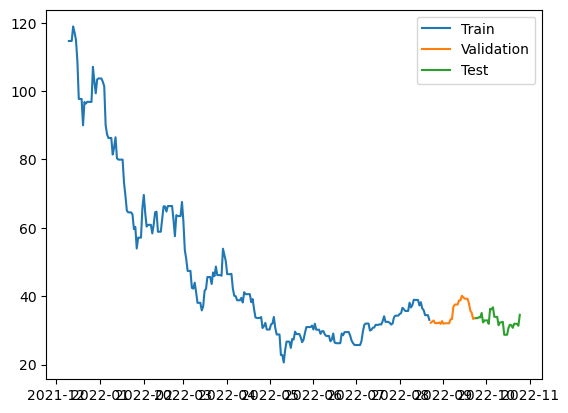

In [74]:
# Performing a train, val, test split
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [75]:
#Creating an LSTM model with an LSTM input layer and 3 dense layers with dropout
model_1 = Sequential()
model_1.add(LSTM(30, input_shape= (30,1)))
model_1.add(Dropout(0.2))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(32, activation = 'relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(1))

model_1.compile(loss='mse', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
8/8 [==============================] - 6s 212ms/step - loss: 2966.3643 - mean_absolute_error: 48.8163 - val_loss: 1225.5470 - val_mean_absolute_error: 34.8815
Epoch 2/100
8/8 [==============================] - 0s 28ms/step - loss: 2940.9634 - mean_absolute_error: 48.5609 - val_loss: 1207.1151 - val_mean_absolute_error: 34.6163
Epoch 3/100
8/8 [==============================] - 0s 34ms/step - loss: 2913.8220 - mean_absolute_error: 48.2731 - val_loss: 1186.3007 - val_mean_absolute_error: 34.3141
Epoch 4/100
8/8 [==============================] - 0s 30ms/step - loss: 2878.4631 - mean_absolute_error: 47.8750 - val_loss: 1154.4097 - val_mean_absolute_error: 33.8454
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 2814.5991 - mean_absolute_error: 47.1904 - val_loss: 1099.1060 - val_mean_absolute_error: 33.0171
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 2720.9849 - mean_absolute_error: 46.1531 - val_loss: 989.2104 - val_mean_abso

8/8 [==============================] - 0s 33ms/step - loss: 198.9626 - mean_absolute_error: 10.2959 - val_loss: 14.1638 - val_mean_absolute_error: 3.5050
Epoch 51/100
8/8 [==============================] - 0s 30ms/step - loss: 149.6765 - mean_absolute_error: 8.8224 - val_loss: 2.2068 - val_mean_absolute_error: 1.2672
Epoch 52/100
8/8 [==============================] - 0s 32ms/step - loss: 168.8077 - mean_absolute_error: 9.4485 - val_loss: 10.1061 - val_mean_absolute_error: 2.9518
Epoch 53/100
8/8 [==============================] - 0s 30ms/step - loss: 150.2679 - mean_absolute_error: 9.2998 - val_loss: 35.2500 - val_mean_absolute_error: 5.8098
Epoch 54/100
8/8 [==============================] - 0s 32ms/step - loss: 168.2287 - mean_absolute_error: 9.5687 - val_loss: 7.7345 - val_mean_absolute_error: 2.4718
Epoch 55/100
8/8 [==============================] - 0s 29ms/step - loss: 171.8731 - mean_absolute_error: 9.6598 - val_loss: 8.6006 - val_mean_absolute_error: 2.5989
Epoch 56/100
8/8 [=

8/8 [==============================] - 0s 30ms/step - loss: 134.1781 - mean_absolute_error: 7.9658 - val_loss: 2.5269 - val_mean_absolute_error: 1.2821
Epoch 100/100
8/8 [==============================] - 0s 29ms/step - loss: 159.4858 - mean_absolute_error: 8.9131 - val_loss: 13.1348 - val_mean_absolute_error: 3.4374


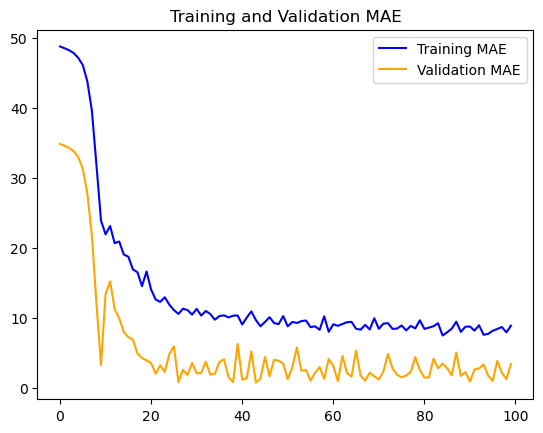

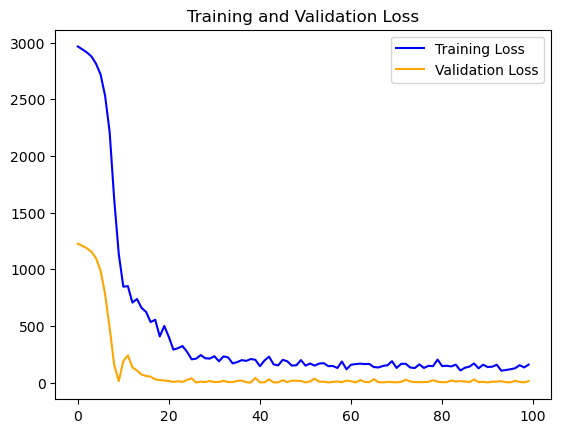

<Figure size 640x480 with 0 Axes>

In [76]:
#This visualizes how the LSTM model is doing based on the metrics given
evaluate_nn(history)

In [77]:
#Saving predictions
train_predictions = model_1.predict(X_train)
val_predictions = model_1.predict(X_val).flatten()
test_predictions= model_1.predict(X_test).flatten()

1/1 [==============================] - 0s 56ms/step


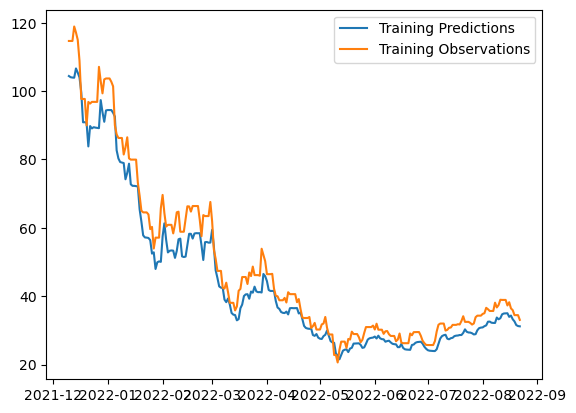

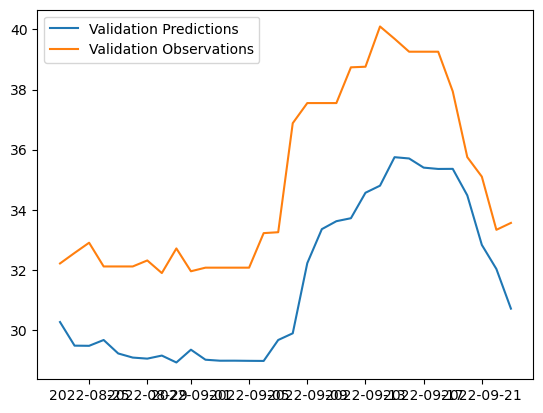

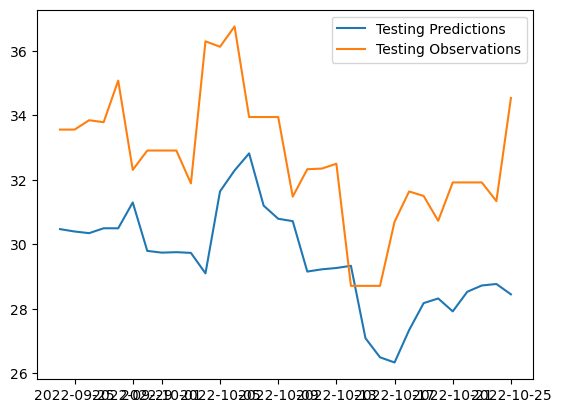

In [78]:
#Plotting the predictions
plot_outcomes_method_1(train_predictions, val_predictions, test_predictions)

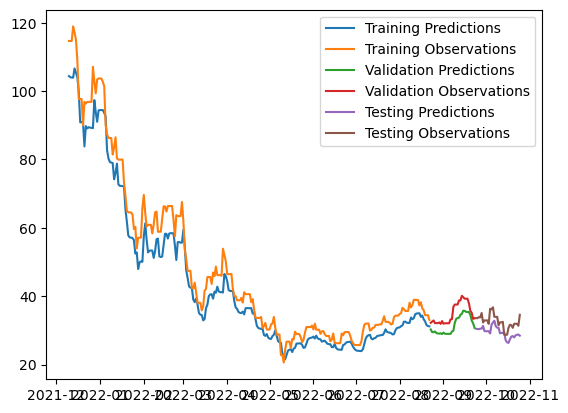

In [79]:
#This plots the predictions all in one plot
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [80]:
#Predicting the future using recursive dates
from copy import deepcopy

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])
last_window = deepcopy(X_train[-1])

for target_date in recursive_dates:
    """
    This loop takes the last period of the windowed dataframe and predicts the next day based on the information. It appends
    that value to the end of the dataframe and shifts the 30 day windows by 1 day to include the new prediction into the
    subsequent prediction.
    
    """
    next_prediction = model_1.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction)
    next_prediction = [next_prediction]
    last_window = np.append(last_window, next_prediction, axis=0)
    last_window = np.delete(last_window, (0), axis=0)

1/1 [==============================] - 0s 56ms/step


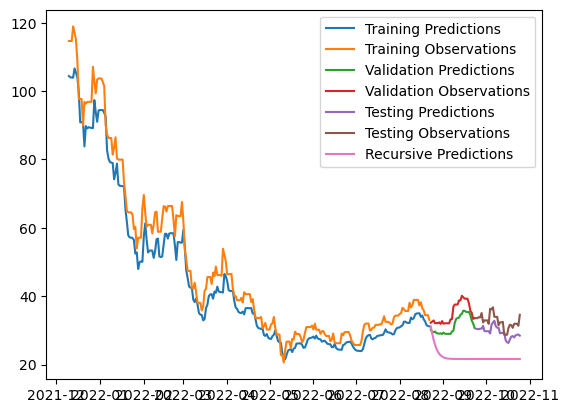

In [81]:
#Plotting results of recursive dates
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
                'Training Observations',
                'Validation Predictions', 
                'Validation Observations',
                'Testing Predictions', 
                'Testing Observations',
                'Recursive Predictions']);

In [82]:
#Checking the output of the predictions
recursive_predictions

[array([31.173405], dtype=float32),
 array([29.100292], dtype=float32),
 array([27.29459], dtype=float32),
 array([25.843212], dtype=float32),
 array([24.6622], dtype=float32),
 array([23.758846], dtype=float32),
 array([23.13103], dtype=float32),
 array([22.679264], dtype=float32),
 array([22.353424], dtype=float32),
 array([22.11741], dtype=float32),
 array([21.945803], dtype=float32),
 array([21.826883], dtype=float32),
 array([21.752277], dtype=float32),
 array([21.707441], dtype=float32),
 array([21.679737], dtype=float32),
 array([21.66239], dtype=float32),
 array([21.650845], dtype=float32),
 array([21.642868], dtype=float32),
 array([21.63718], dtype=float32),
 array([21.633018], dtype=float32),
 array([21.629911], dtype=float32),
 array([21.627552], dtype=float32),
 array([21.625736], dtype=float32),
 array([21.624329], dtype=float32),
 array([21.62322], dtype=float32),
 array([21.62235], dtype=float32),
 array([21.621666], dtype=float32),
 array([21.621124], dtype=float32),
 

## Model 2

In [83]:
#Creating an LSTM model with an LSTM input layer and 3 dense layers without dropout
model_2 = Sequential()
model_2.add(LSTM(30, input_shape= (30,1)))
model_2.add(Dense(32, activation = 'relu'))
model_2.add(Dense(32, activation = 'relu'))
model_2.add(Dense(32, activation = 'relu'))
model_2.add(Dense(1))

model_2.compile(loss='mse', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
8/8 [==============================] - 5s 198ms/step - loss: 2963.4924 - mean_absolute_error: 48.7819 - val_loss: 1220.7880 - val_mean_absolute_error: 34.8130
Epoch 2/100
8/8 [==============================] - 0s 29ms/step - loss: 2940.3889 - mean_absolute_error: 48.5315 - val_loss: 1204.3328 - val_mean_absolute_error: 34.5761
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 2919.4062 - mean_absolute_error: 48.3013 - val_loss: 1185.5898 - val_mean_absolute_error: 34.3038
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 2887.0491 - mean_absolute_error: 47.9512 - val_loss: 1148.6941 - val_mean_absolute_error: 33.7609
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 2827.6206 - mean_absolute_error: 47.2836 - val_loss: 1084.4810 - val_mean_absolute_error: 32.7944
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 2724.3745 - mean_absolute_error: 46.1099 - val_loss: 973.1505 - val_mean_abso

8/8 [==============================] - 0s 29ms/step - loss: 8.1832 - mean_absolute_error: 1.9924 - val_loss: 4.4060 - val_mean_absolute_error: 1.8523
Epoch 51/100
8/8 [==============================] - 0s 28ms/step - loss: 10.1580 - mean_absolute_error: 2.2000 - val_loss: 1.0827 - val_mean_absolute_error: 0.7580
Epoch 52/100
8/8 [==============================] - 0s 29ms/step - loss: 7.9529 - mean_absolute_error: 1.9443 - val_loss: 1.0144 - val_mean_absolute_error: 0.6966
Epoch 53/100
8/8 [==============================] - 0s 30ms/step - loss: 7.5211 - mean_absolute_error: 1.8279 - val_loss: 2.6914 - val_mean_absolute_error: 1.3789
Epoch 54/100
8/8 [==============================] - 0s 31ms/step - loss: 7.8630 - mean_absolute_error: 1.9774 - val_loss: 1.1833 - val_mean_absolute_error: 0.8355
Epoch 55/100
8/8 [==============================] - 0s 30ms/step - loss: 7.1369 - mean_absolute_error: 1.8358 - val_loss: 1.0661 - val_mean_absolute_error: 0.7142
Epoch 56/100
8/8 [================

8/8 [==============================] - 0s 28ms/step - loss: 7.2787 - mean_absolute_error: 1.7928 - val_loss: 0.9551 - val_mean_absolute_error: 0.6355


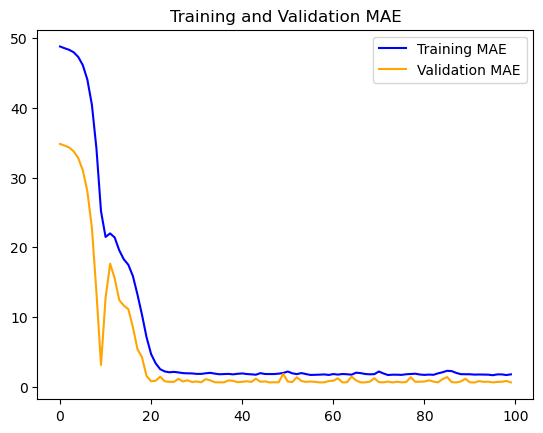

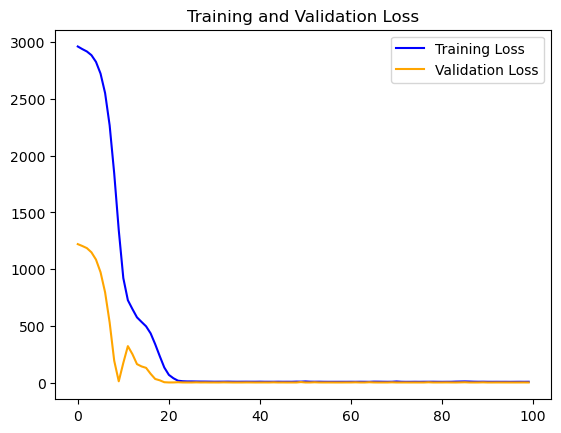

<Figure size 640x480 with 0 Axes>

In [84]:
evaluate_nn(history_2)

In [85]:
#Saving predictions
train_predictions_2 = model_2.predict(X_train)
val_predictions_2 = model_2.predict(X_val).flatten()
test_predictions_2 = model_2.predict(X_test).flatten()

1/1 [==============================] - 0s 56ms/step


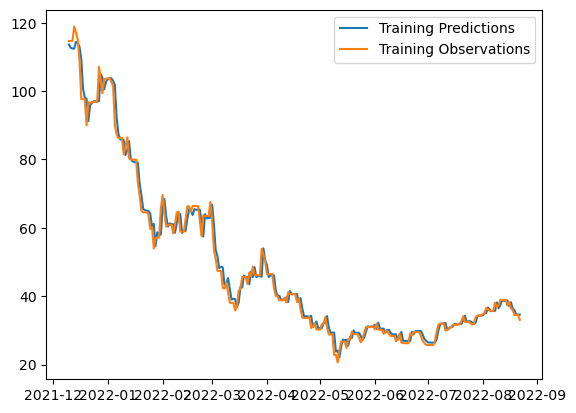

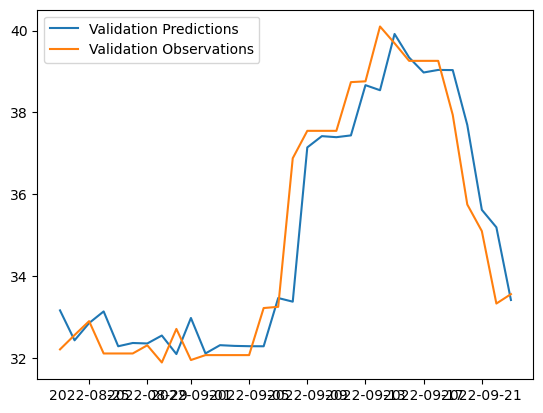

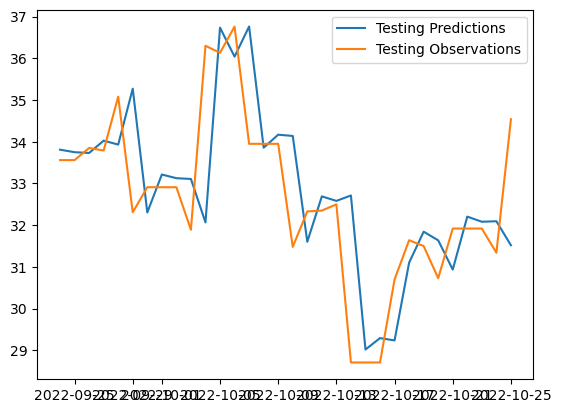

In [86]:
plot_outcomes_method_1(train_predictions_2, val_predictions_2, test_predictions_2)

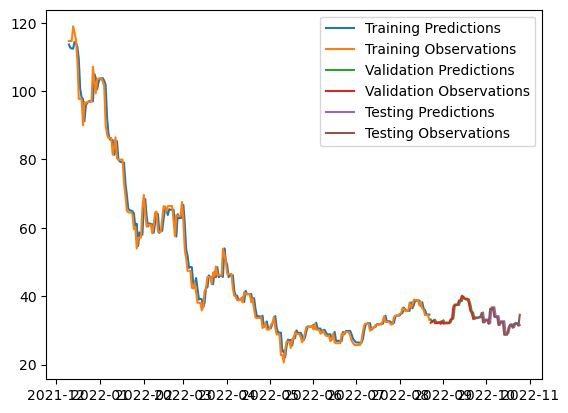

In [87]:
plt.plot(dates_train, train_predictions_2)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions_2)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions_2)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations']);

In [88]:
"""
    This loop takes the last period of the windowed dataframe and predicts the next day based on the information. It appends
    that value to the end of the dataframe and shifts the 30 day windows by 1 day to include the new prediction into the
    subsequent prediction.
    
"""
#Predicting the future using recursive dates
recursive_predictions_2 = []
recursive_dates_2 = np.concatenate([dates_val, dates_test])
last_window_2 = deepcopy(X_train[-1])

for target_date in recursive_dates_2:
    next_prediction = model_2.predict(np.array([last_window])).flatten()
    recursive_predictions_2.append(next_prediction)
    next_prediction = [next_prediction]
    last_window_2 = np.append(last_window_2, next_prediction, axis=0)
    last_window_2 = np.delete(last_window_2, (0), axis=0)

1/1 [==============================] - 0s 51ms/step


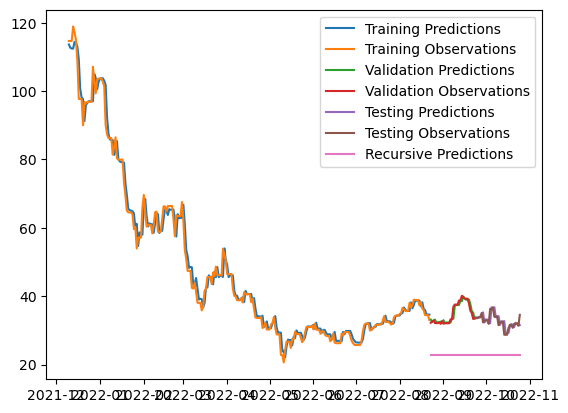

In [89]:
#Plotting results of recursive dates
plt.plot(dates_train, train_predictions_2)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions_2)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions_2)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions_2)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions']);

In [90]:
#Checking the values of the recursive predictions
recursive_predictions_2

[array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], dtype=float32),
 array([22.75947], d

# LSTM Method 2

In [91]:
#Creating a new df for the LSTM model
data= riv_df
new_dataset = pd.DataFrame(index= range(0, len(riv_df)), columns = ['Date', 'Close'])

#Extracts the date and close in the df
for i in range(0, len(data)):
    new_dataset['Date'][i] = data.index[i]
    new_dataset['Close'][i] = data['Close'][i]
   

# Sets the index as a date
new_dataset.index = new_dataset.Date
new_dataset.drop('Date', axis=1, inplace=True)

#Splits the data into training and test
lstm_dataset = new_dataset.values
train_ind = int(len(lstm_dataset)*0.8)
train = lstm_dataset[:train_ind]
val = lstm_dataset[train_ind:]
days = len(val)

#scaling the train data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_train = scaler.fit_transform(train)


X_train, y_train = [], []

#Looping to get the X_train and y_train values
for i in range(days, len(train)):
    X_train.append(scaled_train[i-days:i, 0])
    y_train.append(scaled_train[i, 0])

# Turning the train set into an array for processing
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [92]:
#Creating an LSTM model with an LSTM input layer and 3 dense layers with dropout
model_3 = Sequential()
model_3.add(LSTM(32, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model_3.add(Dropout(0.2))
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(32, activation = 'relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(1))

model_3.compile(loss='mse', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history_3 = model_3.fit(X_train, y_train, epochs = 50)

Epoch 1/50
7/7 [==============================] - 6s 65ms/step - loss: 0.0244 - mean_absolute_error: 0.1247
Epoch 2/50
7/7 [==============================] - 0s 64ms/step - loss: 0.0115 - mean_absolute_error: 0.0780
Epoch 3/50
7/7 [==============================] - 0s 66ms/step - loss: 0.0094 - mean_absolute_error: 0.0791
Epoch 4/50
7/7 [==============================] - 0s 70ms/step - loss: 0.0090 - mean_absolute_error: 0.0783
Epoch 5/50
7/7 [==============================] - 0s 69ms/step - loss: 0.0084 - mean_absolute_error: 0.0728
Epoch 6/50
7/7 [==============================] - 0s 69ms/step - loss: 0.0083 - mean_absolute_error: 0.0716
Epoch 7/50
7/7 [==============================] - 0s 68ms/step - loss: 0.0082 - mean_absolute_error: 0.0728
Epoch 8/50
7/7 [==============================] - 0s 69ms/step - loss: 0.0081 - mean_absolute_error: 0.0735
Epoch 9/50
7/7 [==============================] - 0s 63ms/step - loss: 0.0080 - mean_absolute_error: 0.0728
Epoch 10/50
7/7 [===========

3/3 [==============================] - 2s 19ms/step


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_21864\3665858062.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['Predictions'] = np.average(closing_price, axis=0)


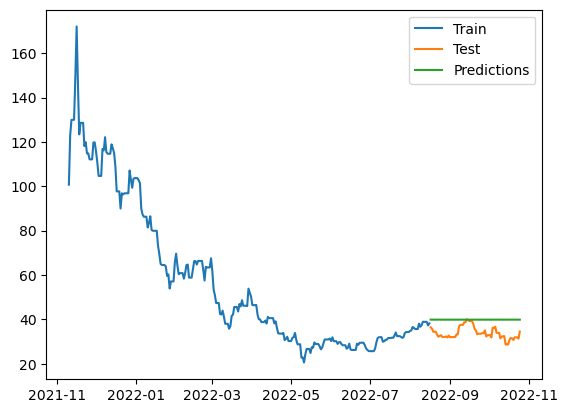

In [93]:
#Adding values and scaling for the test set
inputs_data = new_dataset[len(new_dataset) - len(val) - days:].values
inputs_data = inputs_data.reshape(-1,1)
inputs_data = scaler.transform(inputs_data)

#Loops through values to get the test set.
X_test=[]
for i in range(days, inputs_data.shape[0]):
    X_test.append(inputs_data[i-days:i, 0])
X_test = np.array(X_test)

#Reshapes for predictions
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

closing_price = model_3.predict(X_test)
closing_price = scaler.inverse_transform(closing_price.reshape(-1,1)).reshape(closing_price.shape)


train = new_dataset[:train_ind]
val = new_dataset[train_ind:]
val['Predictions'] = np.average(closing_price, axis=0)

plt.plot(train['Close'])
plt.plot(val[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions']);

In [94]:
#Checking real values cs predictions
val

,Close,Predictions
Date,,
2022-08-17,36.419998,39.910408
2022-08-18,35.900002,39.904732
2022-08-19,34.450001,39.902309
2022-08-20,34.450001,39.901039
2022-08-21,34.450001,39.900059
...,...,...
2022-10-21,31.92,39.905510
2022-10-22,31.92,39.905712
2022-10-23,31.92,39.905872


## Model 2

In [95]:
#Creating an LSTM model with an LSTM input layer and 3 dense layers without dropout
model_4 = Sequential()
model_4.add(LSTM(32, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dense(32, activation = 'relu'))
model_4.add(Dense(1))

model_4.compile(loss='mse', 
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

history_4 = model_4.fit(X_train, y_train, epochs = 50)

Epoch 1/50
7/7 [==============================] - 5s 64ms/step - loss: 0.0182 - mean_absolute_error: 0.1025
Epoch 2/50
7/7 [==============================] - 0s 65ms/step - loss: 0.0085 - mean_absolute_error: 0.0748
Epoch 3/50
7/7 [==============================] - 0s 65ms/step - loss: 0.0086 - mean_absolute_error: 0.0810
Epoch 4/50
7/7 [==============================] - 0s 65ms/step - loss: 0.0078 - mean_absolute_error: 0.0711
Epoch 5/50
7/7 [==============================] - 0s 64ms/step - loss: 0.0076 - mean_absolute_error: 0.0696
Epoch 6/50
7/7 [==============================] - 0s 62ms/step - loss: 0.0074 - mean_absolute_error: 0.0725
Epoch 7/50
7/7 [==============================] - 0s 62ms/step - loss: 0.0075 - mean_absolute_error: 0.0740
Epoch 8/50
7/7 [==============================] - 0s 58ms/step - loss: 0.0075 - mean_absolute_error: 0.0728
Epoch 9/50
7/7 [==============================] - 0s 64ms/step - loss: 0.0075 - mean_absolute_error: 0.0713
Epoch 10/50
7/7 [===========

3/3 [==============================] - 1s 14ms/step


C:\Users\Jonathan\AppData\Local\Temp\ipykernel_21864\2960280665.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_2['Predictions_m2'] = np.average(closing_price_m2, axis=0)


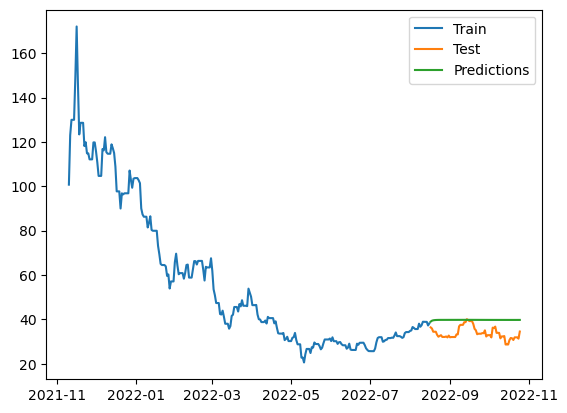

In [96]:
#Saving prediction and reversing scaling transformation
closing_price_m2 = model_4.predict(X_test)
closing_price_m2 = scaler.inverse_transform(closing_price_m2.reshape(-1,1)).reshape(closing_price_m2.shape)

#Setting up train and val
train_2 = new_dataset[:train_ind]
val_2 = new_dataset[train_ind:]
val_2['Predictions_m2'] = np.average(closing_price_m2, axis=0)

#Plotting predictions against actual
plt.plot(train_2['Close'])
plt.plot(val_2[['Close','Predictions_m2']])
plt.legend(['Train', 'Test', 'Predictions']);

In [97]:
#Checking actual vs predicted
val_2

,Close,Predictions_m2
Date,,
2022-08-17,36.419998,38.992188
2022-08-18,35.900002,39.423504
2022-08-19,34.450001,39.605026
2022-08-20,34.450001,39.690083
2022-08-21,34.450001,39.740295
...,...,...
2022-10-21,31.92,39.772797
2022-10-22,31.92,39.773277
2022-10-23,31.92,39.773979
